## 1. Import Dependencies & Setup

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

In [2]:
# Configure GPU memory growth.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## 2. Load, Scale & Visualize Train Data

In [3]:
print(os.listdir('train'))

['Covid19', 'Normal', 'Viral_Pneumonia']


In [4]:
data=tf.keras.utils.image_dataset_from_directory('train',image_size=(224,224))

Found 251 files belonging to 3 classes.


In [5]:
classnames=data.class_names
# Class 0 = Covid19 , Class 1 = Normal , Class 2 = Viral_Pneumonia

In [6]:
data_iterator=data.as_numpy_iterator()

In [7]:
batch=data_iterator.next()

In [8]:
print(len(batch))
print(batch[0].shape)
print(batch[1])

2
(32, 224, 224, 3)
[0 2 0 0 0 0 2 1 1 1 0 1 0 0 1 1 0 2 1 1 2 0 0 0 0 0 0 0 2 1 1 0]


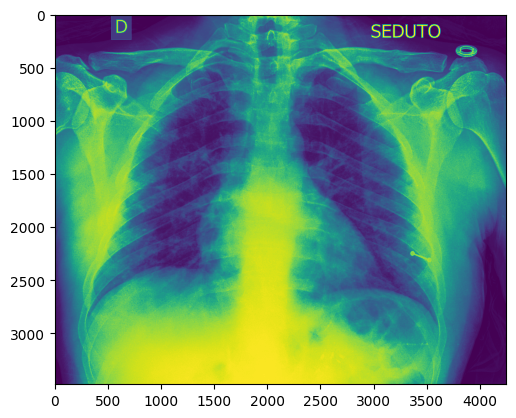

In [9]:
img=cv2.imread(os.path.join('train','Covid19','01.jpeg'))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))

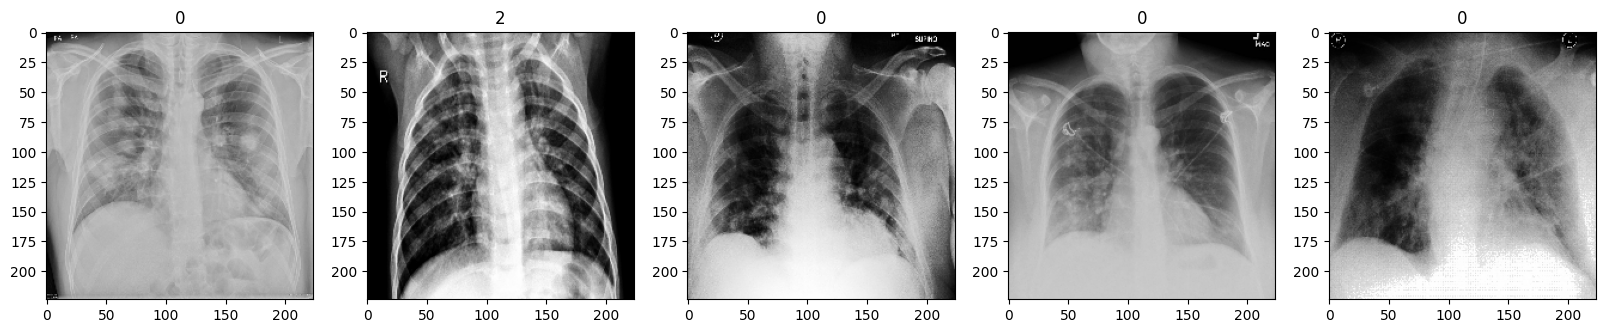

In [10]:
fig, ax=plt.subplots(ncols=5,figsize=(20,20))
for idx,img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
# Scale the pixel values for each image.
data=data.map(lambda x,y: (tf.image.rgb_to_grayscale(x)/255,y))

In [12]:
# Update data iterator & batch.
data_iterator=data.as_numpy_iterator()

In [13]:
batch=data_iterator.next()

In [14]:
# Scaled pixel values.
print(batch[0].min())
print(batch[0].max())

0.0
0.99990004


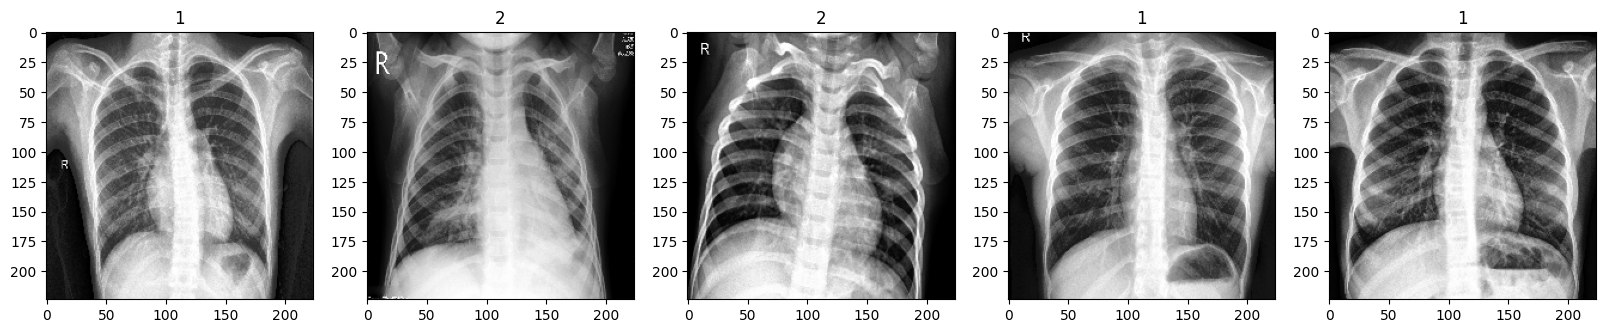

In [15]:
fig, ax=plt.subplots(ncols=5,figsize=(20,20))
for idx,img in enumerate(batch[0][:5]):
    ax[idx].imshow(img,cmap='gray')
    ax[idx].title.set_text(batch[1][idx])

## 3. Load, Scale & Visualize Test Data

In [16]:
# Extract test data from folder "test" and apply the same preprocessing as train data.
test_data=tf.keras.preprocessing.image_dataset_from_directory('test',image_size=(224,224))
print(test_data.class_names)
test_data=test_data.map(lambda x,y: (tf.image.rgb_to_grayscale(x)/255,y))

Found 66 files belonging to 3 classes.
['Covid19', 'Normal', 'Viral_Pneumonia']


In [17]:
test_data_iterator=test_data.as_numpy_iterator()

In [18]:
test_batch=data_iterator.next()

In [19]:
print(batch[0].min())
print(batch[0].max())

0.0
0.99990004


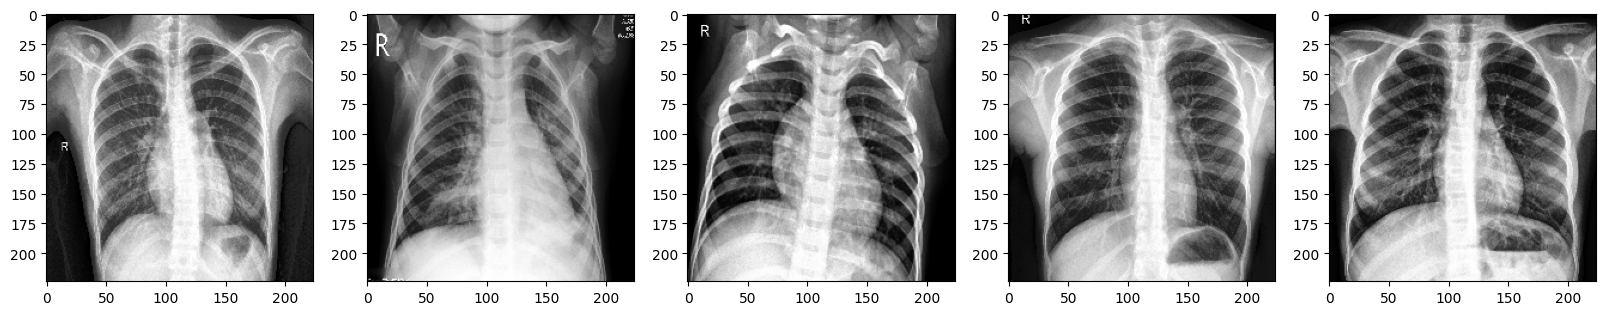

In [20]:
fig, ax=plt.subplots(ncols=5,figsize=(20,20))
for idx,img in enumerate (batch[0][:5]):
    ax[idx].imshow(img,cmap='gray')

In [21]:
print(test_batch[0].max())
print(test_batch[0].min())

0.99990004
0.0


## 4. Splitting data into Train, Val & Test 

In [22]:
len(test_data)

3

In [23]:
len(data)

8

In [24]:
train_size = 6 
val_size = 2
test_size = 3

In [25]:
train = data.take(train_size)
val=data.skip(train_size).take(val_size)
test=test_data

In [26]:
print(len(train))
print(len(val))
print(len(test))

6
2
3


In [27]:
for images, labels in train.take(1):
    print("Image shape:", images.shape)
    print("Image min/max values:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())
    print("Labels shape:", labels.shape)
    print("Unique labels:", np.unique(labels))

Image shape: (32, 224, 224, 1)
Image min/max values: 0.0 0.99990004
Labels shape: (32,)
Unique labels: [0 1 2]


## 5. Building the model architecture

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
tf.keras.backend.clear_session()

model = Sequential()

model.add(Input(shape=(224,224,1)))

model.add(Conv2D((16), (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D((32), (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D((64), (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense((256), activation='relu'))
model.add(Dense((3), activation='softmax'))

adam=Adam(learning_rate=0.001,clipnorm=1.0)
model.compile(optimizer=adam, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [30]:
# Define a logs directory.
logdir = 'logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
# Define the EarlyStopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

## 6. Training the model

In [ ]:
history = model.fit(train, epochs = 40, validation_data = val, callbacks = [tensorboard_callback, early_stopping])

Epoch 1/40
6/6 [==============================] - 9s 444ms/step - loss: 1.2601 - accuracy: 0.5677 - val_loss: 0.4558 - val_accuracy: 0.7797
Epoch 2/40
6/6 [==============================] - 3s 372ms/step - loss: 0.3923 - accuracy: 0.8490 - val_loss: 0.2807 - val_accuracy: 0.8475
Epoch 3/40
6/6 [==============================] - 4s 419ms/step - loss: 0.1796 - accuracy: 0.9323 - val_loss: 0.3038 - val_accuracy: 0.8814
Epoch 4/40
6/6 [==============================] - 3s 360ms/step - loss: 0.1206 - accuracy: 0.9531 - val_loss: 0.1281 - val_accuracy: 0.9322
Epoch 5/40
6/6 [==============================] - 3s 368ms/step - loss: 0.0917 - accuracy: 0.9740 - val_loss: 0.2552 - val_accuracy: 0.9322
Epoch 6/40
6/6 [==============================] - 3s 365ms/step - loss: 0.1075 - accuracy: 0.9583 - val_loss: 0.0369 - val_accuracy: 0.9831
Epoch 7/40
6/6 [==============================] - 3s 358ms/step - loss: 0.0648 - accuracy: 0.9844 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 8/40
6/6 [====

## 7. Visualizing model history

In [ ]:
fig= plt.figure()
plt.plot(history.history['loss'], color='teal', label='Loss')
plt.plot(history.history['val_loss'], color='red', label='Val Loss')
fig.suptitle('Loss', fontsize=15)
plt.legend(loc='lower left')
plt.show()

In [ ]:
fig= plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='Val Accuracy')
fig.suptitle('Accuracy', fontsize=15)
plt.legend(loc='lower left')
plt.show()

## 8. Evaluating the model on test data 

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pr = Precision()
re = Recall()
ca = CategoricalAccuracy()

In [ ]:
for batch in  test.as_numpy_iterator():
    X, y = batch
    yhat= model.predict(X)
    y = tf.one_hot(y, depth=3) #apply one hot encoding so that only one column has a value of 1 and the rest is 0
    pr.update_state(y,yhat)
    re.update_state(y,yhat)
    ca.update_state(y,yhat)    

In [ ]:
print(y.shape,yhat.shape)

In [ ]:
print(pr.result().numpy(),re.result().numpy(),ca.result().numpy())

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

val_labels = []
val_preds = []


for batch in test.as_numpy_iterator():
    X_val, y_val = batch
    val_labels.extend(y_val)
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    val_preds.extend(y_pred_classes)

# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classnames, yticklabels=classnames)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 9. Visualizing a test case

In [ ]:
img = cv2.imread(r"test\\Covid19\\COVID (1).jpg",cv2.IMREAD_GRAYSCALE)
#plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
resize= cv2.resize(img, (224,224))
plt.imshow(resize,cmap='gray')
plt.show()

In [ ]:
resize=np.expand_dims(resize,0)

In [ ]:
resize = np.expand_dims(resize, axis=-1)

In [ ]:
resize=resize/255.0

In [ ]:
print(resize.shape)  # Should be something like (1, 224, 224, 1)

In [ ]:
yhat_test=model.predict(resize)

In [ ]:
yhat_test

In [ ]:
pred_class = np.argmax(yhat_test, axis=1)
if pred_class[0]==0:
    print('Predicted class is Coronavirus.')
elif pred_class[0]==1:
    print('Predicted class is Normal.')
else: 
    print('Predicted class is Viral Pneumonia.')

In [ ]:
pred_class[0]

## 10. Saving the model

In [ ]:
from tensorflow.keras.models import load_model # use this to load the model

In [ ]:
model.save(os.path.join('models','lung_disease_identification1.h5'))